In [5]:


import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms
from tqdm import tqdm
import numpy as np

In [13]:
device = torch.device('cuda:0')
class_order_file = 'class_order.pth'

In [14]:
!pip install pytorch-metric-learning

Defaulting to user installation because normal site-packages is not writeable


In [15]:
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(512,512)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [16]:
!pwd

/home/ubuntu/lialib/colab


In [17]:
torch.cuda.get_device_properties(0)

_CudaDeviceProperties(name='NVIDIA GeForce RTX 3080 Ti', major=8, minor=6, total_memory=12053MB, multi_processor_count=80)

In [18]:
#model.load_state_dict(model_state_dict['rn18'])
import os

if os.path.isfile(class_order_file ):
    class_order = torch.load(class_order_file)
else:
    class_order = torch.randperm(100)
    torch.save(class_order,class_order_file)

In [19]:
class_order

tensor([34, 85, 44, 64, 70, 28, 11,  9, 37,  7,  8, 97,  0, 63, 78, 83, 90,  3,
        50, 19, 51, 31, 86, 58, 57, 67, 47, 45, 27, 69, 20,  1, 36, 24, 46, 32,
        10, 23, 26, 41, 89, 25, 62, 98, 88, 72,  4, 53, 39, 84, 16, 30, 74, 49,
        94, 60, 77, 66, 65, 59, 61, 68, 73, 33, 13, 43, 35, 21, 40, 14,  2, 52,
        76, 15, 29, 75, 96, 55, 80, 99, 87, 92, 12, 71, 22,  6, 54, 18, 38, 82,
        91, 17, 79, 95,  5, 48, 56, 42, 93, 81])

In [20]:
preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(size=(224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
])

In [21]:
ds_train = datasets.CIFAR100(root='./data', train=True, download=True, transform=preprocess)
ds_test  = datasets.CIFAR100(root='./data', train=False, download=True, transform=preprocess)

Files already downloaded and verified
Files already downloaded and verified


In [22]:
def instances_from_classes(dataset, class_order):
    subset = []
    for i in range(len(dataset)):
        _, label = dataset[i]
        if label in class_order:
            subset.append(i)
    return subset


In [23]:
set_train = instances_from_classes(ds_train,class_order[:50])
set_test  = np.array(instances_from_classes(ds_test, class_order[:50]))

In [24]:
set_test.shape

(5000,)

In [25]:
sub_sample_train = sorted(np.random.permutation(set_train)[:300])
sub_sample_test  = sorted(np.random.permutation(set_test)[:300])

In [26]:
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=64, sampler=torch.utils.data.SubsetRandomSampler(set_train))
dl_test = torch.utils.data.DataLoader(ds_test,  batch_size=64, sampler=torch.utils.data.SubsetRandomSampler(set_test))
dl_sub_train = torch.utils.data.DataLoader(ds_train,  batch_size=64, sampler=torch.utils.data.SubsetRandomSampler(sub_sample_train))
dl_sub_test = torch.utils.data.DataLoader(ds_test,  batch_size=64, sampler=torch.utils.data.SubsetRandomSampler(sub_sample_test))

In [27]:
x,y = next(iter(dl_train))

In [28]:
y.shape

torch.Size([64])

In [29]:
y

tensor([78, 64, 20, 19, 34, 34, 28, 25, 28, 26, 89, 85, 64, 47, 70, 45, 39, 50,
        86, 46, 53, 31, 97, 85, 88, 97, 47, 44,  1, 25, 25, 67, 11, 69,  3, 32,
        25, 37, 88, 84, 64, 25,  1, 10, 11, 64, 85, 41, 39, 84, 37, 85, 46, 41,
        78, 41, 63, 86, 69, 64, 63, 27, 78, 84])

In [30]:
from pytorch_metric_learning import losses
loss_func = losses.ArcFaceLoss(num_classes=100,embedding_size=512)


In [31]:
!pip install wandb

Defaulting to user installation because normal site-packages is not writeable


In [32]:
import wandb

In [33]:
wandb.init(
    # set the wandb project where this run will be logged
    project="clip+dmil",
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: edson-matsubara (lablia). Use `wandb login --relogin` to force relogin


In [34]:

opt = optim.Adam(model.parameters(),lr=0.001)

In [35]:
scheduler = optim.lr_scheduler.MultiStepLR(opt,milestones=[45,90],gamma=0.1)

In [36]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [37]:
emb = model(x.to(device))

In [40]:
emb.shape

torch.Size([64, 512])

In [46]:
torch.max(emb,dim=0)

torch.return_types.max(
values=tensor([ 4.2069e-01,  5.9758e-01,  2.2385e+00,  1.3567e-01,  3.8742e-02,
         6.0325e-01,  2.5481e-01,  1.3850e-01,  1.1119e+00,  7.2732e-01,
         5.1480e-01, -1.0458e-01,  2.5447e-01,  7.9023e-01,  1.5948e-01,
        -1.5512e-01,  1.7447e+00,  4.0671e-01,  3.1132e-02,  4.1793e-01,
         1.4596e+00,  4.1460e-01, -6.3997e-02, -5.0993e-01,  1.6078e+00,
         5.7283e-01,  6.4162e-01,  3.9036e-01,  2.2887e+00, -2.4906e-01,
         1.1467e-01, -7.7433e-02,  9.7922e-01,  1.1407e-01,  8.6088e-02,
         5.1566e-01,  5.4188e-01,  1.3553e+00,  2.7462e-01, -2.4379e-01,
        -5.3326e-02,  2.8988e-01,  1.1924e+00,  1.2012e-01, -8.1083e-02,
         7.0074e-01,  3.0859e-01,  7.1555e-01,  1.5813e+00,  2.9214e-01,
         2.6118e+00,  2.0291e-01,  1.9045e+00,  4.9917e-01,  5.5248e-01,
         9.9521e-01, -8.6064e-02,  2.0266e-01,  6.9594e-01,  4.4497e-01,
        -1.8118e-01, -4.4330e-01,  2.6919e-02,  4.6113e-01,  5.1345e-01,
        -3.8046e-01,

In [48]:
torch.std(emb,dim=0)

tensor([0.1444, 0.1047, 0.2382, 0.1949, 0.1767, 0.1568, 0.1537, 0.1508, 0.2137,
        0.1231, 0.1478, 0.1755, 0.1162, 0.1297, 0.1752, 0.1826, 0.2080, 0.2031,
        0.1270, 0.1385, 0.2166, 0.1322, 0.3300, 0.2825, 0.2785, 0.1222, 0.1313,
        0.1345, 0.2887, 0.2581, 0.1243, 0.1875, 0.1413, 0.1510, 0.1060, 0.2241,
        0.1041, 0.1895, 0.1177, 0.1688, 0.2203, 0.1823, 0.1651, 0.1812, 0.2072,
        0.1238, 0.2912, 0.1421, 0.1856, 0.2220, 0.3703, 0.1247, 0.2520, 0.1666,
        0.1132, 0.1658, 0.4648, 0.1365, 0.1555, 0.2742, 0.2393, 0.5840, 0.3056,
        0.1421, 0.1414, 0.1879, 0.1195, 0.1495, 0.2430, 0.1372, 0.1249, 0.2403,
        0.1108, 0.4051, 0.2203, 0.1364, 0.1917, 0.1612, 0.1042, 0.1287, 0.1548,
        0.2026, 0.1765, 0.2015, 0.2341, 0.1668, 0.1245, 0.1547, 0.1369, 0.1003,
        0.3630, 0.1627, 0.1433, 0.1240, 0.1446, 0.2166, 0.2700, 0.1498, 0.2389,
        0.0862, 0.3041, 0.2236, 0.1320, 0.1557, 0.2477, 0.1083, 0.3085, 0.1951,
        0.1251, 0.1617, 0.1837, 0.1832, 

In [38]:
y

tensor([78, 64, 20, 19, 34, 34, 28, 25, 28, 26, 89, 85, 64, 47, 70, 45, 39, 50,
        86, 46, 53, 31, 97, 85, 88, 97, 47, 44,  1, 25, 25, 67, 11, 69,  3, 32,
        25, 37, 88, 84, 64, 25,  1, 10, 11, 64, 85, 41, 39, 84, 37, 85, 46, 41,
        78, 41, 63, 86, 69, 64, 63, 27, 78, 84])

In [51]:
from sklearn.manifold import TSNE

In [57]:
emb.to('cpu')


tensor([[ 0.1932,  0.2269,  0.8811,  ...,  0.6827, -0.6993, -0.3515],
        [ 0.2132,  0.2689,  0.9015,  ...,  0.5296, -0.5968, -0.0841],
        [ 0.0117,  0.2165,  0.6903,  ...,  0.4961, -0.7836, -0.2573],
        ...,
        [ 0.1014,  0.2884,  0.6751,  ...,  0.5806, -0.4240, -0.3492],
        [-0.0475,  0.1421,  0.6518,  ...,  0.7068, -0.5045, -0.2642],
        [ 0.1380,  0.2357,  0.7666,  ...,  0.8977, -0.8127, -0.1830]],
       grad_fn=<ToCopyBackward0>)

In [92]:
torch.max(emb[0]),torch.min(emb[0]),torch.mean(emb[0]),torch.std(emb[0])

(tensor(1.4532, device='cuda:0', grad_fn=<MaxBackward1>),
 tensor(-1.3681, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(0.0016, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.4966, device='cuda:0', grad_fn=<StdBackward0>))

In [217]:
point = 28

In [246]:
vizinhos = emb[point]+(torch.randn(100,512)/10000).to(device)

In [262]:
emb[0].shape[0]

torch.Size([512])

In [263]:
emb[0].device

device(type='cuda', index=0)

In [264]:
def create_neighbors(emb,n_neighbors,):
    return emb+(torch.randn(n_neighbors,emb.shape[0])/10000).to(emb.device)


In [247]:
vizinhos

tensor([[ 0.4207,  0.2511,  0.4806,  ...,  0.6509, -0.6031, -0.1632],
        [ 0.4206,  0.2510,  0.4806,  ...,  0.6509, -0.6029, -0.1630],
        [ 0.4207,  0.2511,  0.4805,  ...,  0.6509, -0.6030, -0.1633],
        ...,
        [ 0.4207,  0.2510,  0.4805,  ...,  0.6510, -0.6032, -0.1634],
        [ 0.4207,  0.2510,  0.4805,  ...,  0.6509, -0.6030, -0.1632],
        [ 0.4207,  0.2510,  0.4805,  ...,  0.6508, -0.6031, -0.1631]],
       device='cuda:0', grad_fn=<AddBackward0>)

In [248]:
emb.shape

torch.Size([64, 512])

In [249]:
vizinhos.shape

torch.Size([100, 512])

In [250]:
torch.cat([emb,vizinhos],dim=0)

tensor([[ 0.1932,  0.2269,  0.8811,  ...,  0.6827, -0.6993, -0.3515],
        [ 0.2132,  0.2689,  0.9015,  ...,  0.5296, -0.5968, -0.0841],
        [ 0.0117,  0.2165,  0.6903,  ...,  0.4961, -0.7836, -0.2573],
        ...,
        [ 0.4207,  0.2510,  0.4805,  ...,  0.6510, -0.6032, -0.1634],
        [ 0.4207,  0.2510,  0.4805,  ...,  0.6509, -0.6030, -0.1632],
        [ 0.4207,  0.2510,  0.4805,  ...,  0.6508, -0.6031, -0.1631]],
       device='cuda:0', grad_fn=<CatBackward0>)

In [251]:

tsne = TSNE(2, verbose=1)
tsne_proj = tsne.fit_transform(torch.cat([emb,vizinhos],dim=0).to('cpu').detach().numpy())

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 164 samples in 0.000s...
[t-SNE] Computed neighbors for 164 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 164 / 164
[t-SNE] Mean sigma: 0.001381
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.434036
[t-SNE] KL divergence after 1000 iterations: 0.808244


In [252]:
y

tensor([78, 64, 20, 19, 34, 34, 28, 25, 28, 26, 89, 85, 64, 47, 70, 45, 39, 50,
        86, 46, 53, 31, 97, 85, 88, 97, 47, 44,  1, 25, 25, 67, 11, 69,  3, 32,
        25, 37, 88, 84, 64, 25,  1, 10, 11, 64, 85, 41, 39, 84, 37, 85, 46, 41,
        78, 41, 63, 86, 69, 64, 63, 27, 78, 84])

In [253]:
from matplotlib import cm
import matplotlib.pyplot as plt

In [254]:
y[point]

tensor(1)

In [255]:
test_targets = y

In [256]:
y_viz = torch.tensor(y.tolist()+[y[point]]*100)

In [257]:
y[28]

tensor(1)

In [258]:
y_viz

tensor([78, 64, 20, 19, 34, 34, 28, 25, 28, 26, 89, 85, 64, 47, 70, 45, 39, 50,
        86, 46, 53, 31, 97, 85, 88, 97, 47, 44,  1, 25, 25, 67, 11, 69,  3, 32,
        25, 37, 88, 84, 64, 25,  1, 10, 11, 64, 85, 41, 39, 84, 37, 85, 46, 41,
        78, 41, 63, 86, 69, 64, 63, 27, 78, 84,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1])

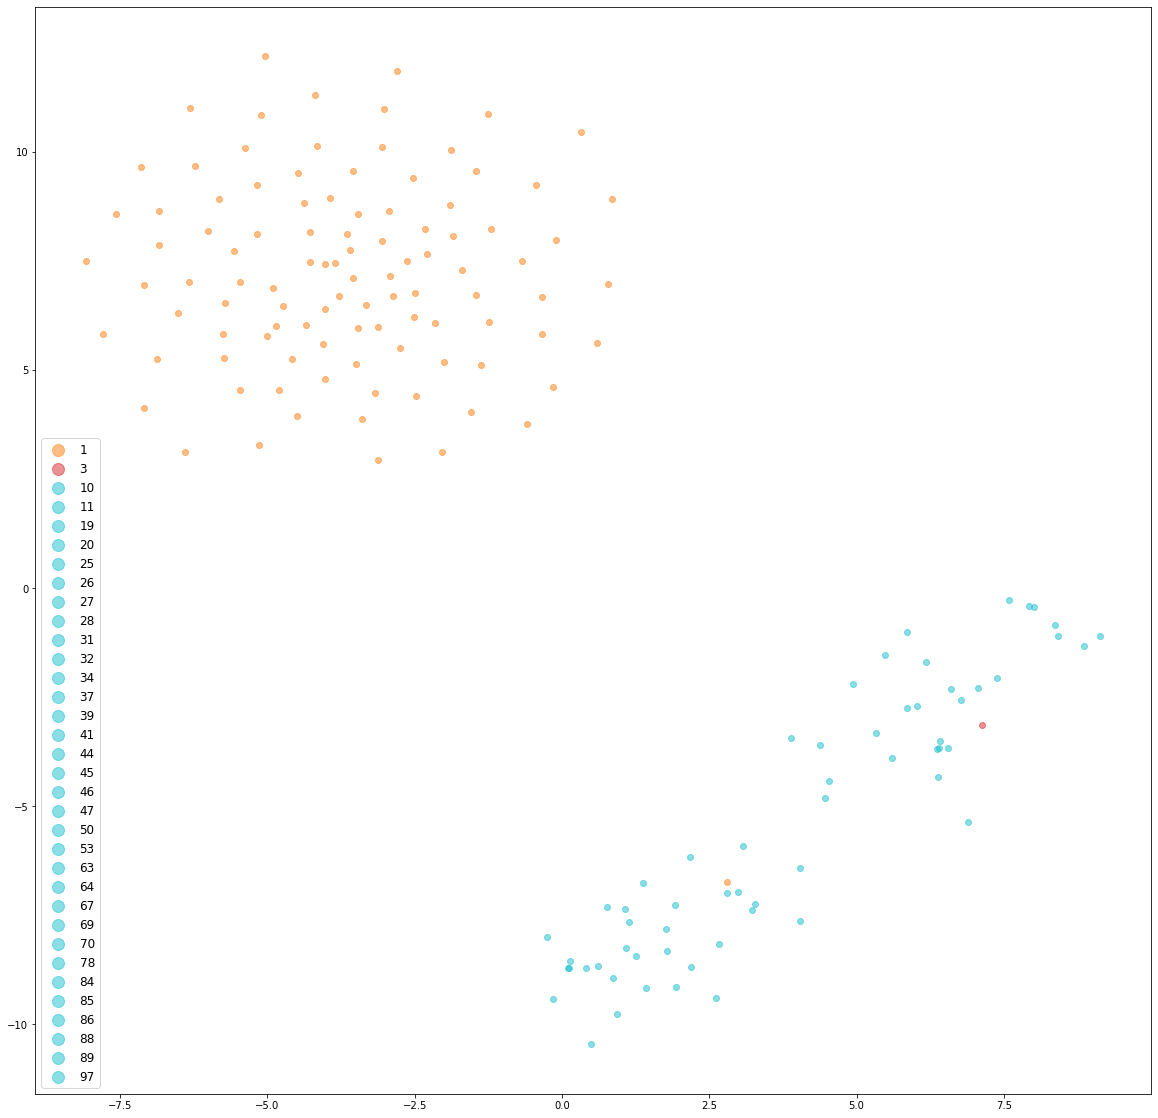

In [259]:
cmap = cm.get_cmap('tab10')
fig, ax = plt.subplots(figsize=(20,20))
num_categories = 100
for lab in range(num_categories):
    if lab in y_viz:
        indices = y_viz==lab
        ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()

In [260]:
np.unique(y,return_counts=True)

(array([ 1,  3, 10, 11, 19, 20, 25, 26, 27, 28, 31, 32, 34, 37, 39, 41, 44,
        45, 46, 47, 50, 53, 63, 64, 67, 69, 70, 78, 84, 85, 86, 88, 89, 97]),
 array([2, 1, 1, 2, 1, 1, 5, 1, 1, 2, 1, 1, 2, 2, 2, 3, 1, 1, 2, 2, 1, 1,
        2, 5, 1, 2, 1, 3, 3, 4, 2, 2, 1, 2]))

In [75]:
def get_embeddings(lmodel,dl):
    lmodel.to(device)
    loop = tqdm(dl)
    lpred = []
    ly = []
    with torch.no_grad():
        for x,y in loop:
            x = x.to(device)
            y = y.to(device)
            pred = lmodel(x)
            lpred = lpred+pred.tolist()
            ly    = ly + y.tolist()
    return lpred,ly

In [76]:
import sklearn.neighbors as neighbors

In [77]:
from sklearn.metrics import classification_report

In [78]:
def pred_knn_model(model,dl_local_train,dl_local_test):
    train_emb,train_y = get_embeddings(model,dl_local_train)
    test_emb,test_y   = get_embeddings(model,dl_local_test)
    train_emb  = np.array(train_emb)
    train_y    = np.array(train_y)
    test_emb   = np.array(test_emb)
    test_y     = np.array(test_y)
    clf = neighbors.KNeighborsClassifier(n_neighbors=1,weights='distance')
    clf.fit(train_emb,train_y.T)
    pred = clf.predict(test_emb)
    return pred,test_y


In [79]:
pred,test_y = pred_knn_model(model,dl_sub_train,dl_sub_test)

100%|██████████| 5/5 [00:00<00:00,  8.62it/s]


In [80]:
pred.shape,test_y.T.shape

((300,), (300,))

In [81]:
print(classification_report(test_y.T,pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.12      0.33      0.18         3
           3       0.10      0.09      0.10        11
           4       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         4
           9       0.50      0.12      0.20         8
          10       0.00      0.00      0.00         6
          11       0.00      0.00      0.00         6
          19       0.00      0.00      0.00         7
          20       0.00      0.00      0.00         5
          23       0.50      0.14      0.22         7
          24       0.00      0.00      0.00         7
          25       0.00      0.00      0.00         7
          26       0.00      0.00      0.00         4
          27       0.12      0.17      0.14         6
          28       0.00      0.00      0.00         6
          31       0.00    

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [68]:
model.to(device)
loss_func.to(device)
loss_train = []
for epoch in range(100):
    model.train()
    loop = tqdm(dl_train)
    lloss = []
    for data, labels in loop:
        data = data.to(device)
        labels = labels.to(device)
        opt.zero_grad()
        embeddings = model(data)
        loss = loss_func(embeddings, labels)
        loss.backward()
        lloss.append(loss.item())
        opt.step()
    scheduler.step()
    if epoch %10 == 0:
        pred,test_y = pred_knn_model(model,dl_sub_train,dl_sub_test)
        print(classification_report(test_y.T,pred))
    loss_train.append(np.mean(lloss))
    print(f"loss {loss_train[-1]}")
    wandb.log({'loss_train':loss_train[-1]})

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.37it/s]
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please ch

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           5       0.25      0.12      0.17         8
           7       0.00      0.00      0.00         7
           8       0.06      0.17      0.08         6
           9       1.00      0.40      0.57         5
          10       0.25      0.20      0.22         5
          14       0.00      0.00      0.00         2
          16       0.14      0.10      0.12        10
          20       0.00      0.00      0.00         4
          21       0.25      0.29      0.27         7
          22       0.00      0.00      0.00         9
          25       0.50      0.20      0.29         5
          30       0.33      0.29      0.31         7
          31       0.00      0.00      0.00        10
          32       0.00      0.00      0.00         3
          33       0.12      0.14      0.13         7
          34       0.14      0.40      0.21         5
          35       0.00    

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:52<00:00,  7.52it/s]


31.019898787788723


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:51<00:00,  7.63it/s]


29.935821938087873


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:52<00:00,  7.44it/s]


28.62053679444296


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:50<00:00,  7.68it/s]


27.120988748262604


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:51<00:00,  7.60it/s]


25.421004849016818


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:52<00:00,  7.50it/s]


23.671112797144428


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:51<00:00,  7.57it/s]


21.953275646395085


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:52<00:00,  7.44it/s]


20.022183298759753


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:52<00:00,  7.38it/s]


18.08702154232718


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.95it/s]
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please ch

              precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           5       0.62      0.62      0.62         8
           7       0.57      0.57      0.57         7
           8       1.00      1.00      1.00         6
           9       1.00      0.80      0.89         5
          10       0.44      0.80      0.57         5
          14       0.00      0.00      0.00         2
          16       1.00      0.60      0.75        10
          20       0.67      1.00      0.80         4
          21       0.50      0.57      0.53         7
          22       0.75      0.67      0.71         9
          25       0.20      0.20      0.20         5
          30       0.83      0.71      0.77         7
          31       0.80      0.40      0.53        10
          32       0.00      0.00      0.00         3
          33       0.14      0.43      0.21         7
          34       0.43      0.60      0.50         5
          35       1.00    

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:52<00:00,  7.52it/s]


13.437952836761085


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:52<00:00,  7.47it/s]


10.454065650930184


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:51<00:00,  7.59it/s]


7.612692526844151


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:52<00:00,  7.38it/s]


4.822003871888456


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:52<00:00,  7.51it/s]


2.793253205049678


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:51<00:00,  7.56it/s]


1.755534179156165


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:52<00:00,  7.45it/s]


1.1299871373207062


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:51<00:00,  7.60it/s]


0.9332857975817245


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:52<00:00,  7.51it/s]


0.8325563215012269


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.17it/s]
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please ch

              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           5       0.38      0.62      0.48         8
           7       1.00      0.71      0.83         7
           8       1.00      1.00      1.00         6
           9       0.83      1.00      0.91         5
          10       0.71      1.00      0.83         5
          14       1.00      1.00      1.00         2
          16       1.00      0.50      0.67        10
          20       0.57      1.00      0.73         4
          21       0.60      0.43      0.50         7
          22       0.60      0.67      0.63         9
          25       0.40      0.40      0.40         5
          30       0.75      0.86      0.80         7
          31       1.00      0.60      0.75        10
          32       1.00      0.67      0.80         3
          33       0.14      0.57      0.23         7
          34       0.80      0.80      0.80         5
          35       0.33    

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:51<00:00,  7.59it/s]


0.7518772025964201


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:51<00:00,  7.59it/s]


0.7088958141904579


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:51<00:00,  7.53it/s]


0.7337500331310026


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:52<00:00,  7.45it/s]


0.6785653142831883


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:51<00:00,  7.54it/s]


0.5931627893539005


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:52<00:00,  7.43it/s]


0.5417063843685409


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:52<00:00,  7.49it/s]


0.6184583438737037


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:51<00:00,  7.58it/s]


0.5181209920841793


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:51<00:00,  7.52it/s]


0.5824253135571136


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.99it/s]
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please ch

              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           5       0.50      0.50      0.50         8
           7       0.83      0.71      0.77         7
           8       1.00      1.00      1.00         6
           9       0.83      1.00      0.91         5
          10       0.38      0.60      0.46         5
          14       1.00      1.00      1.00         2
          16       0.83      0.50      0.62        10
          20       1.00      1.00      1.00         4
          21       0.67      0.57      0.62         7
          22       0.83      0.56      0.67         9
          25       0.67      0.40      0.50         5
          30       0.83      0.71      0.77         7
          31       1.00      0.50      0.67        10
          32       0.40      0.67      0.50         3
          33       0.12      0.86      0.20         7
          34       0.83      1.00      0.91         5
          35       0.40    

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:53<00:00,  7.33it/s]


0.536527235562208


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:52<00:00,  7.47it/s]


0.44886507108095536


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:52<00:00,  7.39it/s]


0.45256215154387025


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:51<00:00,  7.58it/s]


0.45885719853652746


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:51<00:00,  7.61it/s]


0.5044970195712651


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:52<00:00,  7.48it/s]


0.4321603376469414


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:52<00:00,  7.41it/s]


0.4721386983818115


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:52<00:00,  7.47it/s]


0.4447549077119813


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:51<00:00,  7.56it/s]


0.4194581565642134


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.88it/s]
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please ch

              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           5       0.17      0.62      0.27         8
           7       1.00      0.71      0.83         7
           8       1.00      0.83      0.91         6
           9       0.83      1.00      0.91         5
          10       0.71      1.00      0.83         5
          14       1.00      0.50      0.67         2
          16       1.00      0.40      0.57        10
          20       0.50      0.75      0.60         4
          21       0.83      0.71      0.77         7
          22       0.58      0.78      0.67         9
          25       0.50      0.40      0.44         5
          30       0.46      0.86      0.60         7
          31       0.88      0.70      0.78        10
          32       1.00      0.67      0.80         3
          33       0.57      0.57      0.57         7
          34       0.50      0.60      0.55         5
          35       0.67    

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:52<00:00,  7.41it/s]


0.31026352296900234


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:51<00:00,  7.58it/s]


0.13298748215347156


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:52<00:00,  7.48it/s]


0.04753176633424987


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:52<00:00,  7.52it/s]


0.03515834478090245


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:51<00:00,  7.52it/s]


0.022601287522445803


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:52<00:00,  7.48it/s]


0.02473739934932654


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:51<00:00,  7.57it/s]


0.021464283940735608


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:52<00:00,  7.49it/s]


0.02019252590894704


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:51<00:00,  7.54it/s]


0.021970521193152234


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.84it/s]
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please ch

              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           5       0.60      0.75      0.67         8
           7       0.86      0.86      0.86         7
           8       1.00      0.67      0.80         6
           9       1.00      1.00      1.00         5
          10       0.71      1.00      0.83         5
          14       1.00      0.50      0.67         2
          16       1.00      0.50      0.67        10
          20       0.80      1.00      0.89         4
          21       1.00      0.57      0.73         7
          22       0.64      0.78      0.70         9
          25       0.50      0.20      0.29         5
          30       0.62      0.71      0.67         7
          31       0.78      0.70      0.74        10
          32       1.00      0.67      0.80         3
          33       0.12      0.71      0.20         7
          34       0.38      0.60      0.46         5
          35       1.00    

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:52<00:00,  7.44it/s]


0.015217515025333117


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:51<00:00,  7.54it/s]


0.015624345456068988


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:51<00:00,  7.61it/s]


0.013660363638724166


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:51<00:00,  7.55it/s]


0.015095129197002012


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:51<00:00,  7.57it/s]


0.01248625124668722


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:52<00:00,  7.47it/s]


0.013357057294145469


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:51<00:00,  7.62it/s]


0.01633069652365998


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:51<00:00,  7.54it/s]


0.010784355423211454


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:51<00:00,  7.54it/s]


0.01424728353586823


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.55it/s]
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please ch

              precision    recall  f1-score   support

           0       0.60      0.60      0.60         5
           5       0.62      0.62      0.62         8
           7       1.00      0.86      0.92         7
           8       1.00      0.67      0.80         6
           9       0.83      1.00      0.91         5
          10       0.83      1.00      0.91         5
          14       0.50      0.50      0.50         2
          16       1.00      0.50      0.67        10
          20       0.80      1.00      0.89         4
          21       1.00      0.43      0.60         7
          22       0.56      0.56      0.56         9
          25       1.00      0.20      0.33         5
          30       0.83      0.71      0.77         7
          31       1.00      0.70      0.82        10
          32       0.50      0.33      0.40         3
          33       0.50      0.57      0.53         7
          34       0.36      0.80      0.50         5
          35       1.00    

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:52<00:00,  7.50it/s]


0.012204807803954007


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:51<00:00,  7.59it/s]


0.012273815751591057


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:51<00:00,  7.59it/s]


0.008575294047396785


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:51<00:00,  7.57it/s]


0.013826742768038589


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:52<00:00,  7.43it/s]


0.010790015459469043


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:51<00:00,  7.65it/s]


0.008720048530946326


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:49<00:00,  7.86it/s]


0.010668364696314771


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:51<00:00,  7.66it/s]


0.009982987767112346


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:49<00:00,  7.89it/s]


0.012731620468387758


 16%|████████████████████████▎                                                                                                                                | 62/391 [00:08<00:42,  7.70it/s]

In [ ]:
torch

<module 'torch' from '/home/ubuntu/.local/lib/python3.10/site-packages/torch/__init__.py'>

In [ ]:
torch.cuda.get_device_properties(0)

_CudaDeviceProperties(name='NVIDIA GeForce RTX 3060', major=8, minor=6, total_memory=12044MB, multi_processor_count=28)

In [ ]:
torch.save({'rn18':model.state_dict(),'class_order':class_order,'loss_train':loss_train},'rn18_pass_100epochs.pth')